In [1]:
import numpy as np
import rasterio

In [14]:
import rasterio, os, re
from rasterio.rio import stack

class eoTempStack:
    """
    Class to construct and analyze a multi temporal stack of earth observation images. Supports Sentinel-1, Sentinel-2,
    Landsat 7 and Landsat 8 products. 
    """
    def __init__(self, sourcedir, outdir, prodtype):
        """
        Class constructor.
        
        @sourcedir (str): location of products as described in @prodtype
        @outdir (str): directory to store resulting data products (raster stack)
        @prodtype (str): accepts 'S1', 'S2', 'L7', 'L8' where
                            'S1': set of .img files with the same extent and polarization, product from SNAP collocation Op
                            'S2': set of directories resulting from sen2cor processing Sentinel-2 level 2A product
        """        
        self.source_directory = sourcedir
        self.prod_type = prodtype
        self.out_directory = outdir
        
        self.stack_location = ''
        
        self.bands_temporal_range = []
        self.bands_polarization = []
        self.bands_cloud_quality = []
        self.bands_orig_files = []
        
        print(self.prod_type + ' empty object initialized from ' + self.source_directory)
        
    def buildStack(self):
        if self.prod_type == 'S1':
            print('Building stack file...')
            
            ## Get names of files to stack in raster
            
            # get all files in directory
            prodlist = os.listdir(self.source_directory)
            # retain only files with img extension
            prodlist = filter(re.compile(r'img$').search, prodlist)
            # append the data directory to the filename to get full path
            prodlist = list(map(lambda x: self.source_directory+x, prodlist))
            # set band files location in list
            self.bands_orig_files = prodlist
            
            
            ## Set the metadata to store in stackfile 
            self.setMetadata()
            
            ## Set stack product location namefile
            self.setStackLoc()
            
            ## Read and stack (TODO: update using rasterio.stack)
            
            # read metadata of first file
            with rasterio.open(prodlist[0]) as src0:
                meta = src0.meta
            
            # update meta to reflect the number of layers
            meta.update(count = len(prodlist))
            
            # read each layer and write it to stack
            with rasterio.open(self.stack_location, 'w', **meta) as dst:
                for id, layer in enumerate(prodlist):
                    with rasterio.open(layer) as src1:
                        # band numbering in rasterio goes from 1
                        dst.write_band(id + 1, src1.read(1))
                        # update metadata with date of image
                        dst.update_tags(id + 1, date=self.bands_temporal_range[id])
                        dst.update_tags(id + 1, pol=self.bands_polarization[id])
                        # print stored band metadata
                        # print(dst.tags(id + 1))
            print ('Stack file has been saved as: ' + self.stack_location)
        
        if self.prod_type == 'S2':
            ## Get names of files to stack in raster
            print('To do')
            
            ## Calculate the quality based on cloud cover quality_cloud_confidence > limit && quality_scene_classification == 8
            
            # Read the quality_cloud_confidence raster at 60m resolution (make the subset first)
            
            #cloud_pixels_mask = data[0] > 9
            #cloud_cover = 1 - float(np.sum(cloud_pixels_mask)) / float(cloud_pixels_mask.size)
    
    def setMetadata(self):
        if self.prod_type == 'S1':
            # get all files in directory
            prodlist = os.listdir(self.source_directory)
            # retain only files with img extension
            prodlist = filter(re.compile(r'img$').search, prodlist)
            
            # set the band dates list as bands_temporal_range
            self.bands_temporal_range = list(map(lambda x: x[10:18], prodlist))
            # set the band polarization list as polarization
            self.bands_polarization = list(map(lambda x: x[7:9], prodlist))
            
        if self.prod_type == 'S2':
            # get all LC2 source bands
            print('to do')
            
    def setStackLoc(self):
        if self.prod_type == 'S1':
            self.stack_location = self.out_directory+ self.prod_type +'_stack_' + self.bands_temporal_range[0] + \
            self.bands_temporal_range[len(self.bands_temporal_range)-1] + '_' + self.bands_polarization[0] + '.tif'
        else:
            self.stack_location = self.out_directory+ self.prod_type +'_stack_' + self.bands_temporal_range[0] + \
            self.bands_temporal_range[len(self.bands_temporal_range)-1] + '.tif'
    
    def loadProductArray(self):
        with rasterio.open(self.stack_location) as src:
            r = src.read()
        return r
    
    def readBand(band_name):
        """ToDO: read band from raster stack with the indicated band name"""
    

In [ ]:

## After stacking the date has the format 01Jan1999
# to parse this to date format, the following can be done.
import datetime
date = datetime.datetime.strptime(inputvalue, '%d/%b/%Y').date()


In [27]:
# Initialize object
radar_vv = eoTempStack('D:/eo_data/Ibague/data/prep/VV_specklefil_dB.data/', 'D:/eo_data/Ibague/data/', 'S1')
radar_vh = eoTempStack('D:/eo_data/Ibague/data/prep/VH_specklefil_dB.data/', 'D:/eo_data/Ibague/data/', 'S1')
# Build stack
radar_vv.buildStack()
radar_vh.buildStack()

S1 empty object initialized from D:/eo_data/Ibague/data/prep/VV_specklefil_dB.data/
S1 empty object initialized from D:/eo_data/Ibague/data/prep/VH_specklefil_dB.data/
Building stack file...
Stack file has been saved as: D:/eo_data/Ibague/data/S1_stack_2017060220180128_VV.tif
Building stack file...
Stack file has been saved as: D:/eo_data/Ibague/data/S1_stack_2017060220180128_VH.tif


In [29]:
band1 = radar_vv.loadProductArray()

In [30]:
band1.shape

(21L, 1428L, 1643L)

In [12]:
dirlist = os.listdir("D:/eo_data/Ibague/data")
prdlist = filter(re.compile(r'^S2.....L2A').search, dirlist)
list(prdlist)

['S2A_MSIL2A_20171210T152631_N0206_R025_T18NVK_20171210T170838.SAFE']

## Read S-2 example

In [16]:
sentinel2_dir = "D:/eo_data/Ibague/data/"

s2_ = eoTempStack(sentinel2_dir, 'D:/eo_data/Ibague/data/', 'S2')

S2 empty object initialized from D:/eo_data/Ibague/data/


In [11]:
s2_cloud_jp2 = "D:/eo_data/Ibague/data/S2A_MSIL2A_20171210T152631_N0206_R025_T18NVK_20171210T170838.SAFE/GRANULE/L2A_T18NVK_A012892_20171210T152634/QI_DATA/L2A_T18NVK_20171210T152631_CLD_60m.jp2"

#jp2s = ["/tmp/B01.jp2", "/tmp/B09.jp2", "/tmp/B10.jp2"]
arrs = []

with rasterio.open(s2_cloud_jp2) as f:
    arrs.append(f.read(1))

data = np.array(arrs, dtype=arrs[0].dtype)
data.shape


(1L, 1830L, 1830L)

In [12]:
data.dtype

dtype('uint8')

In [13]:
#### gdal reprojection

from osgeo import gdal, gdalconst

inputfile = #Path to input file
input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
inputProj = input.GetProjection()
inputTrans = input.GetGeoTransform()

referencefile = #Path to reference file
reference = gdal.Open(referencefile, gdalconst.GAReadOnly)
referenceProj = reference.GetProjection()
referenceTrans = reference.GetGeoTransform()
bandreference = reference.GetRasterBand(1)    
x = reference.RasterXSize 
y = reference.RasterYSize


outputfile = #Path to output file
driver= gdal.GetDriverByName('GTiff')
output = driver.Create(outputfile,x,y,1,bandreference.DataType)
output.SetGeoTransform(referenceTrans)
output.SetProjection(referenceProj)

gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)

del output


In [14]:
#np.sum(bad_pixels)

#data

In [8]:
cloud_pixels_mask = data[0] > 9
cloud_cover = 1 - float(np.sum(cloud_pixels_mask)) / float(cloud_pixels_mask.size)

In [9]:
print cloud_cover

0.400828331691


In [102]:
from pprint import pprint
import rasterio
import numpy as np

path = radar_vv.stack_location
with rasterio.open(path) as src:
    array = src.read()

stats = []
i = 0
for band in array:
    ## First band has an error, is an empty band. From pre-processing in SNAP
    if i>0:
        stats.append({
            'min': band.min(),
            'mean': band.mean(),
            'median': np.median(band),
            'max': band.max()})
    i = i + 1

pprint(stats)

[{'max': 24.210934, 'mean': -8.817488, 'median': -8.756077, 'min': -24.761158},
 {'max': 23.672045, 'mean': -9.930789, 'median': -9.939377, 'min': -24.93194},
 {'max': 27.089819,
  'mean': -10.362202,
  'median': -10.394039,
  'min': -24.494234},
 {'max': 25.344566,
  'mean': -10.439367,
  'median': -10.537282,
  'min': -25.614614},
 {'max': 26.775578,
  'mean': -10.894947,
  'median': -11.015265,
  'min': -24.782732},
 {'max': 26.058949, 'mean': -9.558783, 'median': -9.597055, 'min': -24.783323},
 {'max': 26.774279, 'mean': -9.653883, 'median': -9.638872, 'min': -25.472023},
 {'max': 24.02989,
  'mean': -10.7197275,
  'median': -10.861368,
  'min': -25.61646},
 {'max': 24.58976, 'mean': -10.540494, 'median': -10.684661, 'min': -26.08511},
 {'max': 27.294153, 'mean': -9.116091, 'median': -9.133263, 'min': -24.8971},
 {'max': 24.374712, 'mean': -9.44039, 'median': -9.38195, 'min': -26.146618},
 {'max': 26.366924, 'mean': -9.546412, 'median': -9.493198, 'min': -25.246605},
 {'max': 23.46

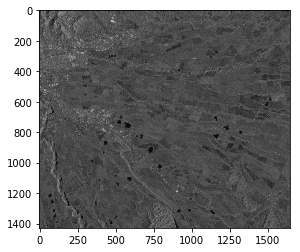

In [105]:
from rasterio.plot import show_hist
from matplotlib import pyplot

with rasterio.open(radar_vv.stack_location, 'r') as src:
    
    ## Histogram of values in a band
    
    #show_hist(src.read(5), bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")
    
    ## 2-D plot of a band in raster
    pyplot.imshow(src.read(5), cmap='gist_gray')
    pyplot.show()

In [109]:
## Read raster bands directly to Numpy arrays.
with rasterio.open(radar_vv.stack_location) as src:
    r = src.read(2)

# Combine arrays in place. Expecting that the sum will
# temporarily exceed the 8-bit integer range, initialize it as
# a 64-bit float (the numpy default) array. Adding other
# arrays to it in-place converts those arrays "up" and
# preserves the type of the total array.
total = np.zeros(r.shape)
total = r
#for band in r, g, b:
#    total += band
#total /= 3

print(total)
print(total.mean())

[[-14.442285  -14.385927  -13.71005   ... -12.045914  -10.946045
   -9.73858  ]
 [-14.436144  -12.844044  -12.306133  ...  -9.964807   -8.826512
   -7.950416 ]
 [-13.300525  -11.922127  -10.508951  ...  -8.596113   -7.516251
   -6.773493 ]
 ...
 [ -8.759519   -8.851126   -8.346581  ...  -9.826294  -11.018783
  -11.769825 ]
 [ -8.965732   -9.055018   -8.149572  ...  -9.940113  -11.063294
  -11.890546 ]
 [ -8.544774   -8.4334135  -8.427343  ... -10.141455  -10.724653
  -10.985925 ]]
-8.817488


In [110]:
with rasterio.open(radar_vv.stack_location) as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)

(1643, 1428)
CRS({'init': u'epsg:4326'})
[-75.1865348950781, 8.98315284119523e-05, -0.0, 4.4686296672161, -0.0, -8.98315284119523e-05]
21
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21)


C:\Anaconda2\envs\spatial-analysis\lib\site-packages\IPython\core\interactiveshell.py:2882: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1282, 938)
CRS({'init': u'epsg:32618'})
[471315.0, 30.0, 0.0, 500055.0, 0.0, -30.0]
8
(1, 2, 3, 4, 5, 6, 7, 8)


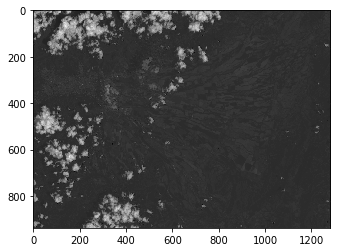

In [119]:
s1_loc = 'D:/eo_data/Ibague/LC08/pre/Ibague/LC08_L1TP_008057_20180301_20180308_01_T1.tif'

band_names = ["sr_band2", "sr_band3", "sr_band4", "sr_band5", "sr_band6", "sr_band7", "pixel_qa", "sr_aerosol"]

with rasterio.open(s1_loc) as src:
    
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)
    i = 0
    while i > 8:
        print(src.tags())
    
    pyplot.imshow(src.read(1), cmap='gist_gray')
    pyplot.show()